In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torchvision.models as models
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import timeit

%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
import copy
import os
import cv2

torch.manual_seed(40)
torch.cuda.manual_seed(40)
np.random.seed(2)

In [2]:
cuda0 = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(cuda0)
print(torch.cuda.is_available())

cuda
True


In [3]:
torch.cuda.device_count()

2

In [4]:
class SoccerDataset(Dataset):
    
    '''This is a class for creating an iterable dataset of images and annotated masks'''
    
    
    def __init__(self, path, image_dir, mask_dir, image_size, transform=None):
        '''Constructor method for the class
            
            Parameters
            ----------
            path : string
                Path of the dataset directory.
            image_dir : string
                Name of folder where images are stored
            mask_dir : string
                Name of folder where annotated masks are stored
            image_size : int
                Size to which the input image has to be resized.
            transform : string
                Name of transforms to be applied to the dataset. Eg: h_flip (horizontal flip)    
                
        '''
        
        super(SoccerDataset, self).__init__()
        
        self._path = path
        self._image_dir = image_dir
        self._mask_dir = mask_dir
        self._transform = transform
        self._image_size = image_size
        self._file_list = os.listdir(self._path+image_dir)
        
    def __len__(self):
        '''This function returns the number of images in the dataset'''
        
        return len(self._file_list)
        
    def __getitem__(self, idx):
        '''This function returns a tensor of an image and its mask
        
        The function iterates through the images as per the index argument, reads them and
        resizes them according to the required image size, and returns a dictionary of
        image and annotated mask tensors.
        
        Parameters
        ----------
        idx : int
            Index of the image to be read
            
        Returns
        -------
        dict 
            An image - mask tensor pair is returned as a dictionary
            
        '''
        
        image_name = self._file_list[idx]
        image_path = os.path.join(self._path, self._image_dir, image_name)
        mask_path = os.path.join(self._path, self._mask_dir, image_name.split('.')[0]+ '.png')
        
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, 0)
        
        image = cv2.resize(image, (self._image_size[0], self._image_size[1]))
        mask = cv2.resize(mask, (self._image_size[0]//4, self._image_size[1]//4))
        
        image, mask = self._get_transforms(image, mask, self._transform)

        image = np.transpose(image, [2,0,1]).astype(np.float32)

        img_mask_pair = {'image':torch.from_numpy(image), 'mask':torch.LongTensor(mask)}
        
        #print(img_mask_pair['image'].size(), img_mask_pair['mask'].size())
        
        return img_mask_pair
    
    def _get_transforms(self, image, mask, transforms):
        '''Method to implement transforms to be applied on dataset
        
        Only horizontal flip transform which is required for this project is implemented.
        Additional transforms can be implemented by added several if else loops in the 
        code below.
        
        Parameters
        ----------
        tranforms : List
            List of string names of transforms.
            
        Returns
        -------
        Numpy array
            Numpy array of transformed image is returned
        Numpy array
            Numpy array of transformed mask is returned
            
        '''
        
        for i in transforms:
            
            if i=='Horizontal_Flip':
                
                p = np.random.rand()
                
                if p>0.5:
                    image = cv2.flip(image, 1)
                    mask = cv2.flip(mask, 1)
                    
            if i=='Brightness_adjust':
                
                p = np.random.rand()
                
                if p>0.5:
                    
                    image = self.brightness_augment(image)
                    
                
        return image, mask
    
    

    def brightness_augment(self, img, factor=0.5): 
        
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        hsv = np.array(hsv, dtype=np.float64)
        hsv[:, :, 2] = hsv[:, :, 2] * (factor + np.random.uniform()) 
        hsv[:, :, 2][hsv[:, :, 2] > 255] = 255 
        rgb = cv2.cvtColor(np.array(hsv, dtype=np.uint8), cv2.COLOR_HSV2RGB)
        
        return rgb
    


In [5]:
def get_dataloader(dataset, BATCH_SIZE):
    '''This function returns the train and validation dataloader.
    
    It implements a train-validation split using SubsetRandomSampler in Pytorch.
    We use a train-val split of 80-20%. First random 80% of the images in the dataset
    are chosen and fed into the train_sampler. The remaining 20% are then put into val_sampler.
    
    Parameters
    ----------
    dataset : object of Dataset class
        Object used to get image, label tensor pair from the dataset folder
    
    Returns
    -------
    list of iter objects
        Returns dataset iter object for training and validation set
        
    '''
    
    train_set_size = int(0.8 * dataset.__len__())   
    train_indices = np.random.choice(np.arange(dataset.__len__()), train_set_size, replace = False) 
    train_sampler = SubsetRandomSampler(train_indices)

    val_indices = np.setdiff1d(np.arange(dataset.__len__()), train_indices, assume_unique= True)
    val_sampler = SubsetRandomSampler(val_indices)

    trainloader = DataLoader(dataset, batch_size = BATCH_SIZE, sampler=train_sampler, num_workers=2)
    valloader = DataLoader(dataset, batch_size = BATCH_SIZE, sampler=val_sampler, num_workers=2)
    
    return trainloader, valloader

In [6]:
PATH = '/opt/datasets/Soccer_dataset/Train_1/'
image_folder = 'JPEG_images'
mask_folder = 'Annotations'
BATCH_SIZE = 8
full_resolution = (640, 480)
downsampled_resolution = (320, 160)

soccer_dataset_low_resolution = SoccerDataset(PATH, image_folder, mask_folder, 
                                              downsampled_resolution, transform=['Horizontal_Flip', 'Brightness_adjust'])
soccer_dataset_full_resolution = SoccerDataset(PATH, image_folder, mask_folder, 
                                               full_resolution, transform=['Horizontal_Flip', 'Brightness_adjust'])

train_loader_low_resolution, val_loader_low_resolution = get_dataloader(soccer_dataset_low_resolution, BATCH_SIZE)
train_loader_full_resolution, val_loader_full_resolution = get_dataloader(soccer_dataset_full_resolution, BATCH_SIZE)

In [7]:
print(f"Total no. of training images : {len(train_loader_low_resolution.sampler)}")
print(f"Total no. of validation images : {len(val_loader_low_resolution.sampler)}")

Total no. of training images : 1994
Total no. of validation images : 499


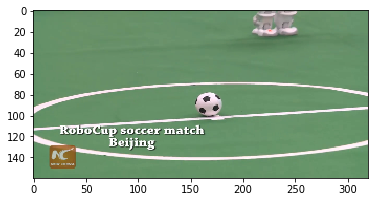

(40, 80)


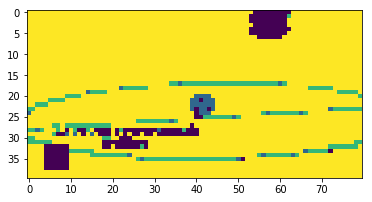

In [8]:
def load_sample_image(dataloader):
    '''Function to load and display a sample image from the dataset
    
    Parameters
    ----------
    dataloader : iter object
        Iter object which iterates through the dataset of images
    
    '''
    
    obj = iter(dataloader)
    data = obj.next()
    
    image = data['image'][0].numpy()
    image = np.transpose(image, [1, 2, 0])
    image = cv2.resize(image, (320, 160))
    image = image.astype(int)
    plt.imshow(image)

    plt.savefig("Results/Sample_image")
    plt.show()
 
    mask = data['mask'][0].numpy()
    print(mask.shape)

    plt.imshow(mask)
    plt.savefig("Results/Sample_mask")
    return image, mask
    
sample_image, sample_mask = load_sample_image(train_loader_low_resolution)

In [9]:
class UNet(nn.Module):
    
    '''This class implements an encoder-decoder similar to UNet'''
    
    
    def __init__(self, resnet_layers):
        '''Constructor method used to create the encoder layers, decode layers and lateral connections'''
        
        super(UNet, self).__init__()
        
        self._encoder_layer_1 = nn.Sequential(*list(resnet_layers.children())[:5])
        
        self._encoder_layer_2 = nn.Sequential(*list(resnet_layers.children())[5])
        
        self._encoder_layer_3 = nn.Sequential(*list(resnet_layers.children())[6])
        
        self._encoder_layer_4 = nn.Sequential(*list(resnet_layers.children())[7])
        
        
        self._decoder_layer_1 = nn.Sequential(nn.ReLU(),
                                      nn.ConvTranspose2d(512, 128, 3, 2, 1, 1))
        
        self._decoder_layer_2 = nn.Sequential(nn.BatchNorm2d(256),
                                      nn.ReLU(),
                                      nn.ConvTranspose2d(256, 128, 3, 2, 1, 1))
        
        self._decoder_layer_3 = nn.Sequential(nn.BatchNorm2d(256),
                              nn.ReLU(),
                              nn.ConvTranspose2d(256, 128, 3, 2, 1, 1))
        
        self._decoder_layer_4 = nn.Sequential(nn.BatchNorm2d(256),
                                      nn.ReLU(),
                                      nn.ConvTranspose2d(256, 4, 3, 1, 1))
        
        self._lateral_conv_1 = nn.Conv2d(64, 128, 1, 1)
        self._lateral_conv_2 = nn.Conv2d(128, 128, 1, 1)
        self._lateral_conv_3 = nn.Conv2d(256, 128, 1, 1)
        
    def encoder(self, x):
        '''Class method used to group all encoder layers
        
        Parameters
        ----------
        x : Float tensor
            Input image tensor to the model of size BATCH_SIZE x C x H x W.
            C - 3
            H, W - 512 for low resolution images and 1024 for full resolution images
            
        Returns
        -------
        Float tensor
            Returns a downsampled feature map of size BATCH_SIZE x 512 x H x W.
            
        '''

        x = self._encoder_layer_1(x)
        self._lateral_outputs.append(x)
        x = self._encoder_layer_2(x)
        self._lateral_outputs.append(x)
        x = self._encoder_layer_3(x)
        self._lateral_outputs.append(x)
        x = self._encoder_layer_4(x)
        
        return x
    
    def decoder(self, x):
        '''Class method used to group all decoder layers
        
        Parameters
        ----------
        x : Float tensor
            Output tensor from encoder of size BATCH_SIZE x 512 x H x W
            
        Returns
        -------
        Float tensor
            Returns an upsampled feature map of size BATCH_SIZE x C x H/4 x W/4.
            C - No. of classes of objects in the image. (4 classes)
            Here we have 3 classes (Ball, field, field lines) + 1 background class.
            The decoder outputs an image whose height and width is reduced 4 times.
            
        '''
        
        x = self._decoder_layer_1(x)
        lateral_output_1 = self._lateral_conv_3(self._lateral_outputs[-1])
        x = torch.cat((x, lateral_output_1), dim=1)
        
        x = self._decoder_layer_2(x)
        lateral_output_2 = self._lateral_conv_2(self._lateral_outputs[-2])
        x = torch.cat((x, lateral_output_2), dim=1)
        
        x = self._decoder_layer_3(x)
        lateral_output_3 = self._lateral_conv_1(self._lateral_outputs[-3])
        x = torch.cat((x, lateral_output_3), dim=1)
        
        x = self._decoder_layer_4(x)
        
        return x
        
    def forward(self, x):
        '''Class method for forward pass through the model.
        
        Parameters
        ----------
        x : Float tensor
            Input image tensor to the model of size BATCH_SIZE x C x H x W.
            C - 3
            H, W - 512 for low resolution images and 1024 for full resolution images
            
        Returns
        -------
        Float tensor
            Returns an upsampled feature map of size BATCH_SIZE x C x H/4 x W/4.
            C - No. of classes of objects in the image. (4 classes)
            Here we have 3 classes (Ball, field, field lines) + 1 background class.
            The decoder outputs an image whose height and width is reduced 4 times.
        
        '''
        
        self._lateral_outputs = []
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [10]:
resnet_layers = models.resnet18(pretrained=True)

for param in resnet_layers.parameters():
    param.requires_grad = False
    
model = UNet(resnet_layers)
#model = nn.DataParallel(model)
model = model.to(cuda0)
   
params = list(model.parameters())[60:]

learning_rate = 0.001

optimizer = optim.Adam(params, lr = learning_rate)

criterion = nn.CrossEntropyLoss().to(cuda0)



In [11]:
class Metric():
    
    '''Class for computing different metrics like IoU'''
    
    
    def __init__(self, num_classes):
        '''Constructor method which initializes the confusion matrix
        
        Parameters
        ----------
        num_classes : int
            No. of classes of objects present in the input image
            
        '''
        
        self.confusion_matrix = np.ndarray((num_classes, num_classes), dtype=np.int64)
        
    def reset(self):
        '''Method to reset the confusion matrix.
        
        It is usually called after one epoch.
        '''
        
        self.confusion_matrix.fill(0)
        
    def get_confusion_matrix(self, predicted, target):
        '''Method to generate a confusion matrix using the predicted and target images.
        
        Parameters
        ----------
        predicted : Float tensor
            A batch of masks output from the model
        target : Float tensor
            A batch of corresponding annotated masks from the dataset
            
        '''
        
        predicted_val = predicted.cpu().detach().numpy()
        target_val = target.detach().cpu().detach().numpy()
        cm = confusion_matrix(target_val.flatten(), predicted_val.flatten())
        self.confusion_matrix += cm
        
    def get_iou(self, predicted, target):
        '''Method to compute the IoU from the confusion matrix
        
        Parameters
        ----------
        predicted : Float tensor
            A batch of masks output from the model
        target : Float tensor
            A batch of corresponding annotated masks from the dataset
        
        '''
        
        self.get_confusion_matrix(predicted, target)
        true_positive = np.diag(self.confusion_matrix)
        false_positive = np.sum(self.confusion_matrix, axis=0) - true_positive
        false_negative = np.sum(self.confusion_matrix, axis=1) - true_positive
        iou = true_positive/(true_positive + false_positive + false_negative)
        
        return (iou, np.nanmean(iou))

In [12]:
def fit(model, criterion, optimizer, **kwargs):
    '''Function to train the model
    
    Parameters
    ----------
    model : object
        Object of class UNet which has the network
    criterion : pytorch loss module
        Contains the loss function for optimizing the model
    optimizer : pytorch optimizer
        Contains the desired optimizer to optimize the model parameters
    **kwargs : dict
        Dictionary of keywords passed to the function
        
    Returns
    -------
    float
        Loss value per epoch
    List of floats
        Loss per batch per epoch
    tuple
        List of iou per class and mean iou
    '''
    
    
    if kwargs['phase'] == 'Training':
        model.train()
    if kwargs['phase'] == 'Validation':
        model.eval()
    
    running_loss = 0
    batch_wise_loss = []
    metric_val = Metric(4)
    metric_val.reset()

    
    for i, data in enumerate(kwargs['dataloader']):
        
        images = data['image'].to(cuda0)
        masks = data['mask'].to(cuda0)

        output = model(images)
        
        loss = criterion(output, masks)
        
        running_loss += loss.item()
        
        batch_wise_loss.append(loss.item())
        
        # Varying learning rate if lr_finder is used
        if kwargs['lr_finder'] == True:
            
            optimizer = optim.Adam(kwargs['parameters'], lr = kwargs['lr_range_val'][i])

        if kwargs['phase'] == 'Training':
            #Backward
            optimizer.zero_grad()
            loss.backward()

            #Update weights
            optimizer.step()
        
        pred = torch.argmax(output, dim=1)
        iou = metric_val.get_iou(pred, masks)

        
    return running_loss/len(kwargs['dataloader']), batch_wise_loss, iou
    
    

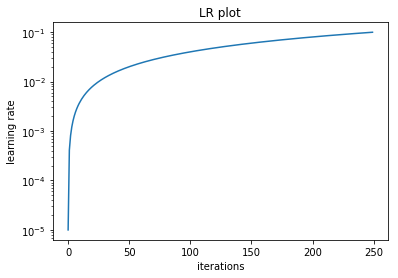

In [13]:
class CyclicLearningRate:
    '''Implementation based on Smith, Leslie N. "Cyclical learning rates for training neural networks."'''
    
    def __init__(self, dataloader, max_lr, base_lr):
        '''Constructor method to initialize parameters of learning rate generator
        
        Parameters
        ----------
        dataloader : iter object
            Iter object which iterates through the dataset of images
        base_lr : float
            Initial learning rate
        max_lr : float
            Maximum learning rate
        
        '''
        
        self.num_iterations = len(dataloader)  
        self.stepsize = len(dataloader)
        self.max_lr = max_lr     
        self.base_lr = base_lr
        
    def calculate_triangular_learning_rate(self, iteration):
        '''Method to generate triangular learning rates 
        
        Parameters
        ----------
        iteration : int
            Iteration number

        Returns
        -------
        Float
            Returns the learning rate for each iteration
        '''

        cycle = np.floor(1 + iteration/(2  * self.stepsize))
        x = np.abs(iteration/self.stepsize - 2 * cycle + 1)
        lr = self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1-x))

        return lr
    
    def get_learning_rate(self):
        '''Method to get the learning rate for each iteration
        
        Returns
        -------
        Float list
            List of learning rates for one epoch
        
        '''
        
        lr_array = []
        for iteration in range(self.num_iterations):
    
            lr = self.calculate_triangular_learning_rate(iteration)
            lr_array.append(lr)
            
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.set(title = 'LR plot', xlabel = 'iterations', ylabel = 'learning rate', yscale = 'log')
        ax.plot(lr_array)
        plt.savefig("Results/learning_rate_plot.png")
        
        return lr_array
        
        
learning_rate = CyclicLearningRate(train_loader_low_resolution, 0.1, 1e-5)
learning_rate_array = learning_rate.get_learning_rate()

In [14]:
def lr_finder_plot(lr_array, batch_loss):
    '''Function to plot learning rate vs batch loss
    
    Parameters
    ----------
    lr_array : list
        List of learning rates per iteration
    batch_loss : list
        List of losses per iteration
        
    '''
    
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    ax1.set(title='lr finder', xlabel='learning rate', ylabel='loss', xscale='log')
    ax1.plot(lr_array, batch_loss)

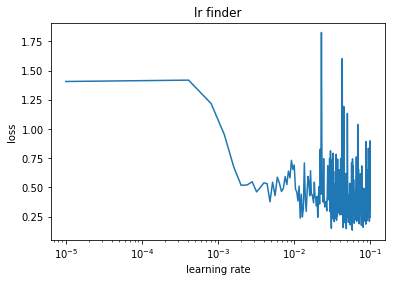

In [15]:
_, batch_loss, _ = fit(model, criterion, optimizer, parameters=params, dataloader=train_loader_low_resolution, 
                       phase='Training', lr_range_val=learning_rate_array, lr_finder=True)
lr_finder_plot(learning_rate_array, batch_loss)

In [16]:
def unfreeze_layers(model):
    '''Function to unfreeze the layers of a model
    
    Parameters
    ----------
    model : object
        Object of class UNet which has the network
        
    Returns
    -------
    List
        List of model parameters
        
    '''
    
    for param in model.parameters():
        param.requires_grad = True
    
    params = list(model.parameters())
    
    return params
    

In [17]:

train_loss_values = []
val_loss_values = []


mean_iou = 0
unfreeze_flag = True
optim_flag = True
learning_rate = 0.001  # Optimal learning rate using lr finder

optimizer = optim.Adam(params, lr = learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience =1)
start_time = timeit.default_timer()
for epoch in range(80):
    
    if epoch>25 and epoch<=40:
        
        if unfreeze_flag:
            params = unfreeze_layers(model)
            optimizer = optim.Adam(params, lr=0.0001)
            unfreeze_flag = False
        
        train_loss, _, train_iou = fit(model, criterion, optimizer, parameters=params, dataloader=train_loader_low_resolution, 
                                       phase='Training', lr_range_val=[], lr_finder=False)
        train_loss_values.append(train_loss)
        
        val_loss, _, val_iou = fit(model, criterion, optimizer, parameters=params, dataloader=val_loader_low_resolution, 
                                       phase='Validation', lr_range_val=[], lr_finder=False)
        val_loss_values.append(val_loss)
        
    elif epoch>40:
        
        if optim_flag:
#             params = [{'params':list(model.parameters())[60:]},
#           {'params':list(model.parameters())[:30], 'lr':1e-6},
#          {'params':list(model.parameters())[30:60], 'lr':1e-5}]

            optimizer = optim.Adam(params, lr=1e-4, weight_decay=0.0005)
            optim_flag = False
        
        train_loss, _, train_iou = fit(model, criterion, optimizer, parameters=params, dataloader=train_loader_full_resolution, 
                                       phase='Training', lr_range_val=[], lr_finder=False)
        train_loss_values.append(train_loss)
        
        val_loss, _, val_iou = fit(model, criterion, optimizer, parameters=params, dataloader=val_loader_full_resolution, 
                                       phase='Validation', lr_range_val=[], lr_finder=False)
        val_loss_values.append(val_loss)
        
    else:
        
        train_loss, _, train_iou = fit(model, criterion, optimizer, parameters=params, dataloader=train_loader_low_resolution, 
                                       phase='Training', lr_range_val=[], lr_finder=False)
        train_loss_values.append(train_loss) 
        
        val_loss, _, val_iou = fit(model, criterion, optimizer, parameters=params, dataloader=val_loader_low_resolution, 
                                       phase='Validation', lr_range_val=[], lr_finder=False)
        val_loss_values.append(val_loss)
    

    print(f'Epoch: {epoch}   Train Loss: {train_loss:.5f}  IoU: {train_iou[0]}  Mean IoU:{train_iou[1]:.5f}')
    print(f'Epoch: {epoch}   Val Loss: {val_loss:.5f}      IoU: {val_iou[0]}    Mean IoU:{val_iou[1]:.5f}')
    
    if val_iou[1]>mean_iou:
        
        model_checkpoint = copy.deepcopy(model.state_dict())
#         model.load_state_dict(model_checkpoint)
#         torch.save(model.state_dict(), "Unet_{}.th".format(epoch))
    
    scheduler.step(val_loss)
    
end_time = timeit.default_timer()

Epoch: 0   Train Loss: 0.31622  IoU: [0.79958185 0.51450439 0.43612876 0.85986762]  Mean IoU:0.65252
Epoch: 0   Val Loss: 0.19609      IoU: [0.91046998 0.58045597 0.45956288 0.9223463 ]    Mean IoU:0.71821
Epoch: 1   Train Loss: 0.20997  IoU: [0.89062974 0.58669923 0.46492736 0.91467135]  Mean IoU:0.71423
Epoch: 1   Val Loss: 0.18104      IoU: [0.91884129 0.58753539 0.45989961 0.92750679]    Mean IoU:0.72345
Epoch: 2   Train Loss: 0.19951  IoU: [0.89678036 0.59695695 0.46903969 0.91854063]  Mean IoU:0.72033
Epoch: 2   Val Loss: 0.17434      IoU: [0.9209034  0.59591076 0.46467261 0.92949997]    Mean IoU:0.72775
Epoch: 3   Train Loss: 0.18916  IoU: [0.9020615  0.60487854 0.47750669 0.92204279]  Mean IoU:0.72662
Epoch: 3   Val Loss: 0.17138      IoU: [0.92252747 0.59413643 0.47035659 0.93037763]    Mean IoU:0.72935
Epoch: 4   Train Loss: 0.18795  IoU: [0.90229902 0.60770354 0.48103561 0.92242058]  Mean IoU:0.72836
Epoch: 4   Val Loss: 0.16987      IoU: [0.92457596 0.59845906 0.471985   0.

In [18]:
model.load_state_dict(model_checkpoint)
torch.save(model.state_dict(), "Unet.th")
#model.load_state_dict(torch.load("pretrained_resnet.th"))

In [ ]:
model.load_state_dict(torch.load("Unet.th"))

In [19]:
def predict(model, testloader, criterion):
    '''Function to evaluate the model
    
    Parameters
    ----------
    model : object
        Object of class UNet which has the network
    criterion : pytorch loss module
        Contains the loss function for optimizing the model
    optimizer : pytorch optimizer
        Contains the desired optimizer to optimize the model parameters
        
    Returns
    -------
    List
        List of predicted mask tensors output from the model
    List
        List of annotated mask tensors from the dataset
    Tuple
        List of iou per class and mean iou
        
    '''
    
    model.eval()
    metric_val = Metric(4)
    metric_val.reset()
    running_loss = 0
    worst_iou=0.8
    
    prediction_array = np.ndarray((BATCH_SIZE, 120, 160))
    mask_array = np.ndarray((BATCH_SIZE, 120, 160))

    
    for i, data in enumerate(testloader):
        
        images = data['image'].to(cuda0)
        masks = data['mask'].to(cuda0)
        
        output = model(images)
        
        loss = criterion(output, masks)
        
        running_loss += loss.item()
        
        pred = torch.argmax(output, dim=1)
        iou = metric_val.get_iou(pred, masks)
        #print(pred.size(), prediction_array.shape)
            
        if iou[1]<0.8:
            prediction_array = np.vstack((prediction_array, pred.detach().cpu().numpy()))
    #print(masks.detach().cpu().numpy().shape, mask_array.shape)
            mask_array = np.vstack((mask_array, masks.detach().cpu().numpy()))
        #print(prediction_array.shape, mask_array.shape)

    return prediction_array, mask_array, iou, metric_val.confusion_matrix
    

In [20]:
prediction_arr, label_arr, iou, cm = predict(model, val_loader_full_resolution, criterion)

In [21]:
print("---------------Validation Set Results----------------\n")
print(f'Per class IoU [Background, Ball, Field lines, Field] : {iou[0]}')
print(f'Mean IoU : {iou[1]}')

---------------Validation Set Results----------------

Per class IoU [Background, Ball, Field lines, Field] : [0.94396734 0.73027235 0.64721274 0.95416359]
Mean IoU : 0.8189040051507366


In [25]:
def plot_mask(prediction, label, cmap):
    '''Function to plot the annotated masks and the predicted masks
    
    Parameters
    ----------
    prediction
        List of predicted mask tensors output from the model
    label 
        List of annotated mask tensors from the dataset
    cmap
        Numpy array of confusion matrix
         
    '''
    
    path = os.getcwd()
    image_folder = '/Results/'
    image_path = path + image_folder
    
    if not os.path.exists(image_path):
        os.makedirs(image_path)
    
    
    for i in range(1, prediction.shape[0]):
        
        label_mask = cmap[np.array(label[i], dtype=np.uint8)]
        
        fig = plt.figure(figsize=(8,10))
        ax = fig.add_subplot(prediction.shape[0], 1, i)
        ax.set(title='True Mask')
        ax.set_axis_off()
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
        ax.imshow(cv2.cvtColor(label_mask, cv2.COLOR_BGR2RGB))
        plt.savefig(os.path.join(image_path, 'label_{0}.png'.format(i)), bbox_inches='tight', pad_inches=0)
    
    for i in range(1, prediction.shape[0]):
        
        prediction_mask = cmap[np.array(prediction[i], dtype=np.uint8)]
        
        fig1 = plt.figure(figsize=(6, 8))
        ax1 = fig1.add_subplot(prediction.shape[0], 1, i)
        ax1.set(title='Predicted Mask')
        ax1.set_axis_off()
        ax1.get_yaxis().set_visible(False)
        ax1.get_xaxis().set_visible(False)
        ax1.imshow(cv2.cvtColor(prediction_mask, cv2.COLOR_BGR2RGB))
        plt.savefig(os.path.join(image_path, 'predicted_mask_{0}.png'.format(i)), bbox_inches='tight', pad_inches=0)
        plt.tight_layout()
        


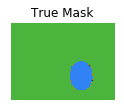

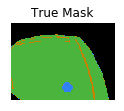

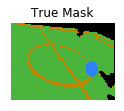

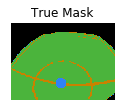

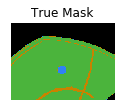

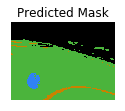

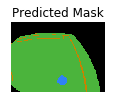

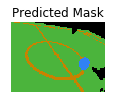

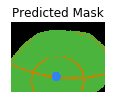

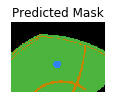

In [27]:
cmap = np.array([[0, 0, 0], [245, 130, 48], [0, 130, 200], [60, 180, 75]], dtype=np.uint8)

x = np.array(prediction_arr[9], dtype=np.uint8)

plot_mask(prediction_arr[9:15], label_arr[9:15], cmap)

('Backround', 'Ball', 'Field Lines', 'Field')


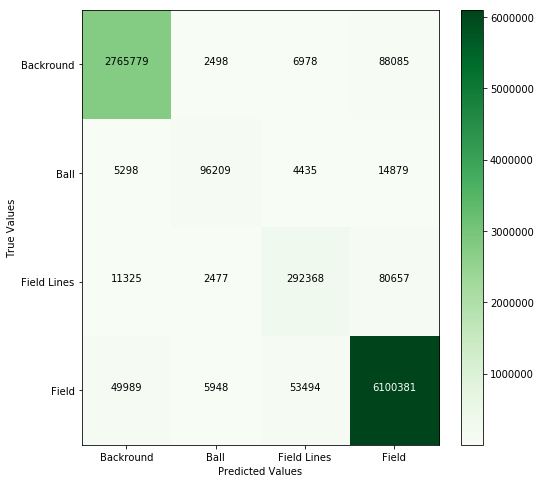

In [24]:
def plot_confusion_matrix(cm, classes):
    '''Function to plot the confusion matrix
    
    Parameters
    ----------
    cm
        Numpy array of confusion matrix
    classes
        List of number of classes of object
    
    '''
    
    tick_marks = np.arange(len(classes))
    cmap = plt.get_cmap('Greens')
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.set(xlabel="Predicted Values", ylabel="True Values", xticks=tick_marks, yticks=tick_marks, 
           xticklabels=classes, yticklabels=classes)
    img = ax.imshow(cm, cmap = cmap, interpolation = 'nearest')
    fig.colorbar(img, ax=ax)
    ax.set_aspect('auto')

    print(classes)
    
    threshold = cm.max()/2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        ax.text(i, j, f'{cm[i, j]}' , horizontalalignment = 'center', 
                 color="white" if cm[i, j] > threshold else "black")
        
    plt.savefig("Results/Confusion_matrix.png")


classes = ('Backround', 'Ball', 'Field Lines', 'Field')
plot_confusion_matrix(cm.T, classes)